# Usefulness Regression for Steam Reviews

An interesting dataset is [available](https://github.com/mulhod/steam_reviews/tree/master/data) on GitHub scraped by the author from the Steam website. As a senior gamer on Steam, I make decisions to purchase games through reading the reviews that are voted useful by the players. If we can show more potentially useful reviews that recommend the game before they accumulate sufficient usefulness votes, we can show those reviews preferentially early and can potentially boost a game's sale. Therefore, I would like to build a regression model from the scraped data including the user's and the review's characteristics to estimate the usefulness rate of a review.

First of all, define a data class to load the data from the json files and define two feature selection methods to filter variables of low importance. One method calculates the mutual information between a feature and the target variable, the usefulness rate. Mutual information between two variables is a well-performing metric measuring how related the two variables are. The other method checks the Pearson correlation coefficients between the independent feature pairs. For feature pairs with high correlation coefficient, remove one of them with a lower mutual information score to reduce redundant features.

First, import libraries that are going to be used. Note that I am utilizing the YellowBrick library for easy visualization.

In [1]:
from pathlib import Path
from yellowbrick.features import Rank2D
from yellowbrick.target import FeatureCorrelation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/Users/sklin/anaconda3/envs/data-science/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Define two helper functions to help preprocess the data columns.

In [2]:
def word_count(rev_str):
    return len(rev_str.split())

def split_achievements(ach_str):
    ach_perc = ach_str['num_achievements_percentage']
    ach_att = ach_str['num_achievements_attained']
    ach_poss = ach_str['num_achievements_possible']
    return ach_perc, ach_att, ach_poss

Now, define the data class which adds a word count column and separates the three achievement columns properly. For this simple analysis I will only extract the word count variable from the reviews. Also defined are the two feature selection methods.

In [3]:
class GameReviews:
    """
    Class for importing data from json files,
    augment data with some preprocessing,
    identify numerical fields, and select features
    according to correlation between features
    and mutual information between a feature and the target value.
    """
    def __init__(self, data_path):
        self.rawdf = pd.read_json(data_path, lines=True)
        self.rawdf.insert(0, 'title', Path(data_path).stem)
        # Adding some more fields to the raw table
        self.rawdf['review_word_count'] = self.rawdf['review'].map(word_count)
        self.rawdf['num_achievements_percentage'], self.rawdf['num_achievements_attained'], self.rawdf['num_achievements_possible'] = zip(*self.rawdf['achievement_progress'].map(split_achievements))
        # For simplicity, replace missing values with 0.
        self.rawdf = self.rawdf.fillna(0)
        self.vis_mi = None
        self.vis_cc = None

    def numeric_features(self):
        return self.rawdf.select_dtypes(include=np.number).columns.tolist()

    def mutual_info(self):
        if self.vis_mi is None:
            y = self.rawdf['found_helpful_percentage'].copy()
            features = self.numeric_features()
            features.remove('found_helpful_percentage')
            X = self.rawdf[features].copy()
            visualizer = FeatureCorrelation(method='mutual_info-regression')
            visualizer.fit(X, y)
            plt.subplots_adjust(left=0.3)
            self.vis_mi = visualizer
        return self.vis_mi

    def corr_coeff(self):
        if self.vis_cc is None:
            y = self.rawdf['found_helpful_percentage'].copy()
            features = self.numeric_features()
            features.remove('found_helpful_percentage')
            X = self.rawdf[features].copy()
            visualizer = Rank2D(algorithm='pearson')
            visualizer.fit(X, y)
            visualizer.transform(X)
            plt.subplots_adjust(left=0.25, bottom=0.45)
            self.vis_cc = visualizer
        return self.vis_cc

    def select_features(self, corr_thr = 0.5, mi_thr = 0.05):
        """
        This method identifies colinear feature pairs and removes the one
        in each pair that has a lower mutual information score.
        Then it removes features with low mutual information scores.
        """
        vis_mi = self.mutual_info()
        vis_cc = self.corr_coeff()
        selected_features = vis_cc.features_.tolist().copy()
        hc_idx = np.argwhere(vis_cc.ranks_ > corr_thr)
        hc_idx = hc_idx[hc_idx[:, 0] < hc_idx[:, 1]]

        for row in hc_idx:
            feature1 = vis_cc.features_[row[0]]
            feature2 = vis_cc.features_[row[1]]
            idx1 = vis_mi.features_.tolist().index(feature1)
            idx2 = vis_mi.features_.tolist().index(feature2)
            remove_feature = feature1
            if vis_mi.scores_[idx2] < vis_mi.scores_[idx1]:
                remove_feature = feature2
            if remove_feature in selected_features:
                selected_features.remove(remove_feature)
        # Remove all features with helpful as substring
        for f in selected_features:
            if 'helpful' in f:
                selected_features.remove(f)
        # Remove features with too small mutual information
        for f in selected_features:
            if vis_mi.scores_[vis_mi.features_.tolist().index(f)] < mi_thr:
                selected_features.remove(f)
        return selected_features

Let's build a model using the dataset with the most reviews, the GTA V dataset. First we load the data into a class instance and show the first several records.

In [4]:
gta5_revs = GameReviews('./data/Grand_Theft_Auto_V.jsonlines')
pd.set_option('display.max_columns', None)

In [5]:
gta5_revs.rawdf.head()

,title,num_found_funny,review_url,num_guides,total_game_hours,num_workshop_items,num_found_unhelpful,steam_id_number,username,num_found_helpful,total_game_hours_last_two_weeks,date_posted,num_comments,profile_url,rating,num_reviews,orig_url,num_groups,num_games_owned,friend_player_level,date_updated,found_helpful_percentage,num_screenshots,review,achievement_progress,num_voted_helpfulness,num_badges,num_friends,review_word_count,num_achievements_percentage,num_achievements_attained,num_achievements_possible
0,Grand_Theft_Auto_V,5,http://steamcommunity.com/profiles/76561198010...,0,116.0,0,161,76561198010454100,God,1199,6.2,"May 31, 2015, 7:33AM",8,http://steamcommunity.com/profiles/76561198010...,Not Recommended,1,http://steamcommunity.com/app/271590/homeconte...,0.0,42,5.0,0,0.881618,0,"Well, hackers got to the point where they use ...","{'num_achievements_possible': 60, 'num_achieve...",1360,2.0,11.0,73,0.200000,12,60
1,Grand_Theft_Auto_V,6,http://steamcommunity.com/profiles/76561197984...,0,187.0,0,163,76561197984446047,tri_nitric,1210,3.9,"May 31, 2015, 2:59PM",12,http://steamcommunity.com/profiles/76561197984...,Not Recommended,1,http://steamcommunity.com/app/271590/homeconte...,4.0,170,41.0,0,0.881282,86,"Hackers, thats all i have to say. Nothing is b...","{'num_achievements_possible': 2, 'num_achievem...",1373,28.0,92.0,25,0.500000,1,2
2,Grand_Theft_Auto_V,0,http://steamcommunity.com/id/calvero/recommend...,0,96.9,0,1165,calvero,calvero,7034,0.0,"Jun 11, 2015, 10:05AM",63,http://steamcommunity.com/id/calvero,Not Recommended,1,http://steamcommunity.com/app/271590/homeconte...,2.0,49,21.0,"Jun 11, 2015, 10:17AM",0.857910,7,"Garbage always-online ""periodic entitlement ve...","{'num_achievements_possible': 88, 'num_achieve...",8199,18.0,41.0,34,0.522727,46,88
3,Grand_Theft_Auto_V,1,http://steamcommunity.com/id/BetterThanYourWai...,1,14.3,0,1458,BetterThanYourWaifu,Utage,8740,0.0,"Jun 11, 2015, 11:49AM",156,http://steamcommunity.com/id/BetterThanYourWaifu,Not Recommended,5,http://steamcommunity.com/app/271590/homeconte...,6.0,140,68.0,"Jun 18, 2015, 2:08PM",0.857031,122,"Game itself is good, but Rockstar is using a p...","{'num_achievements_possible': 16, 'num_achieve...",10198,74.0,52.0,97,0.250000,4,16
4,Grand_Theft_Auto_V,1,http://steamcommunity.com/id/courierncr/recomm...,0,185.0,0,144,courierncr,Courier,1073,22.2,"May 29, 2015, 5:16PM",5,http://steamcommunity.com/id/courierncr,Not Recommended,0,http://steamcommunity.com/app/271590/homeconte...,0.0,0,0.0,"May 30, 2015, 4:13PM",0.881676,0,Long story short. For people who love GTA and ...,"{'num_achievements_possible': None, 'num_achie...",1217,0.0,0.0,148,0.000000,0,0


Let's show the mutual information and the Pearson correlation coefficient with YellowBrick's visualizer.

/Users/sklin/anaconda3/envs/data-science/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


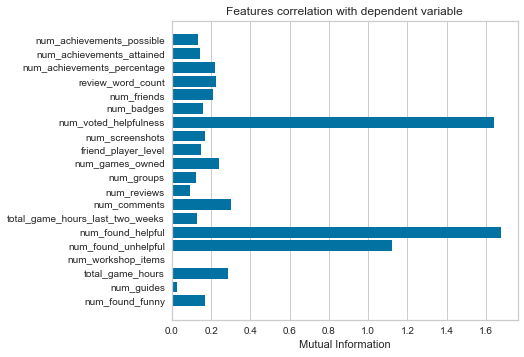

In [6]:
viz_mutual_info = gta5_revs.mutual_info()
viz_mutual_info.show()

In the above plot I will simply ignore the three features with largest mutual information. Indeed, they are directly used for calculating the target variable, and in my model, they are not known beforehand.

/Users/sklin/anaconda3/envs/data-science/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


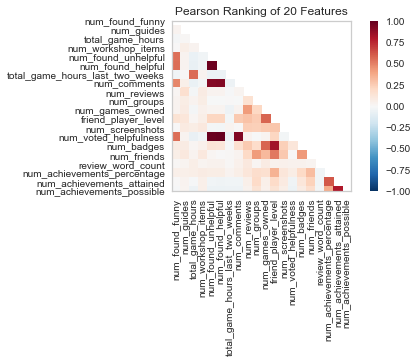

In [7]:
viz_corr_coeff = gta5_revs.corr_coeff()
viz_corr_coeff.show()

We can now select the features entering our model. Note that there is some randomness involved in calculating the mutual information for real-valued features. Therefore, the selected features might change from run to run. In the future, I will assign a random_state in sklearn's sklearn.feature_selection.mutual_info_regression function.

In [8]:
selected_features = gta5_revs.select_features(corr_thr = 0.6)
print(selected_features)

['num_found_funny', 'total_game_hours', 'total_game_hours_last_two_weeks', 'num_reviews', 'num_groups', 'num_games_owned', 'num_screenshots', 'num_badges', 'num_friends', 'review_word_count', 'num_achievements_percentage']


Prepare train and test datasets.

In [16]:
from sklearn.model_selection import train_test_split
X = gta5_revs.rawdf[selected_features]
y = gta5_revs.rawdf['found_helpful_percentage']
validation_size = 0.2
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10679, 11)
(2670, 11)
(10679,)
(2670,)


Evaluate multiple regression methods roughly.

In [20]:
print(y[y[:]<0.1])

3097     0.0
3098     0.0
3099     0.0
3100     0.0
3101     0.0
        ... 
13344    0.0
13345    0.0
13346    0.0
13347    0.0
13348    0.0
Name: found_helpful_percentage, Length: 5010, dtype: float64
